# Set up Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import env
import acquire
import split_scale
from env import user, password, host
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

# Acquire

In [2]:
data = acquire.get_telco_data()
data.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,Month-to-month,DSL,Bank transfer (automatic)


# Prepare

In [3]:
data = acquire.prep_telco_data(data)
data.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
0,2,1,1,1,0,0,0,9,1,2,0,0,0,0,0,2,0,59.9,542.40,0
1,4,1,1,0,0,0,1,9,1,0,0,0,0,2,2,2,1,69.4,571.45,0
2,1,1,1,0,1,0,0,7,1,0,2,0,0,0,0,0,1,48.2,340.35,0
3,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,1,25.1,25.10,1
4,3,1,1,0,0,1,1,1,0,1,2,0,0,0,0,0,0,30.5,30.50,1


## Split Data

In [4]:
train, test = split_scale.split_my_data(data)
# Define X_train variable as target features: everything except churn
X_train = train.drop(columns=["churn"])
y_train = pd.DataFrame([train.churn])
# y_train is our target variable tax value dollar amount
y_train = y_train.transpose()
# This test data won't be used until after we have created a model. It is used to test the effectiveness of the model.
X_test = test.drop(columns=["churn"])
y_test = pd.DataFrame([test.churn])
y_test = y_test.transpose()

In [5]:
X_train.shape

(5625, 19)

In [6]:
X_test.shape

(1407, 19)

In [7]:
y_train.shape

(5625, 1)

In [8]:
y_test.shape

(1407, 1)

# Exploration and Evaluation

## Baseline 1

What is the churn rate?

In [9]:
url = f'mysql+pymysql://{user}:{password}@{host}/telco_churn'
churn_rate = pd.read_sql("select count(churn) as 'customers', churn from customers group by churn",url)
churn_rate

,customers,churn
0,5174,No
1,1869,Yes


Churn Rate = 26.54%

Text(0, 0.5, 'Number of Customers')

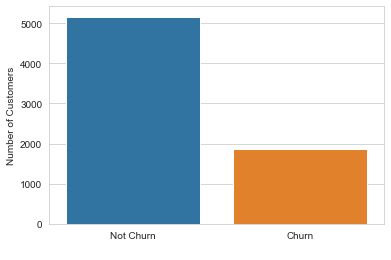

In [10]:
ax = sns.countplot(x= data.churn)
ax.set_xticklabels(["Not Churn","Churn"])
ax.set_xlabel(" ")
ax.set_ylabel("Number of Customers")

### If we were to just guess that every customer had not churned, we would be correct 73.46% of the time. This is Baseline 1. Our goal is to create a model that is more accurate than 73.46%.

## Baseline 2

### This simple model will:
#### - Use a decision tree with only tenure, monthly charges, and total charges as features
#### - Evaluate compared to Baseline 1

In [11]:
X_train_tenure_charges = X_train[['tenure', 'total_charges', 'monthly_charges']]

In [12]:
# Create
baseline_2 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
# Fit
baseline_2.fit(X_train_tenure_charges, y_train)
# Predict
y_pred = baseline_2.predict(X_train_tenure_charges)
# Preview (Zero means not churned, 1 means churned)
y_pred[:10]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [13]:
# Check the probability (First column is chance they will not churn, second column is chance they will churn)
y_pred_proba = baseline_2.predict_proba(X_train_tenure_charges)
y_pred_proba

array([[0.90314136, 0.09685864],
       [0.90314136, 0.09685864],
       [0.3943662 , 0.6056338 ],
       ...,
       [0.90458488, 0.09541512],
       [0.68367347, 0.31632653],
       [0.3943662 , 0.6056338 ]])

In [14]:
# Evaluate accuracy (Checks number of correct predictions over the number of total instances that have been evaluated.)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(baseline_2.score(X_train_tenure_charges, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [15]:
# Confusion Matrix
cmt = confusion_matrix(y_train,y_pred)
cmt

array([[3827,  306],
       [ 901,  591]])

In [16]:
# Classification Report
crt=(classification_report(y_train,y_pred, output_dict=False))
print("Classification Report: \n\n",crt)

Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.93      0.86      4133
           1       0.66      0.40      0.49      1492

    accuracy                           0.79      5625
   macro avg       0.73      0.66      0.68      5625
weighted avg       0.77      0.79      0.77      5625



### Baseline 2 is slightly more accurate than just guessing not churned for every customer. 79% is greater than 73%. This becomes the new number to beat. 

## Exploration Continued 

### Now we will incorporate more features to come up with a model that can beat 79%. 

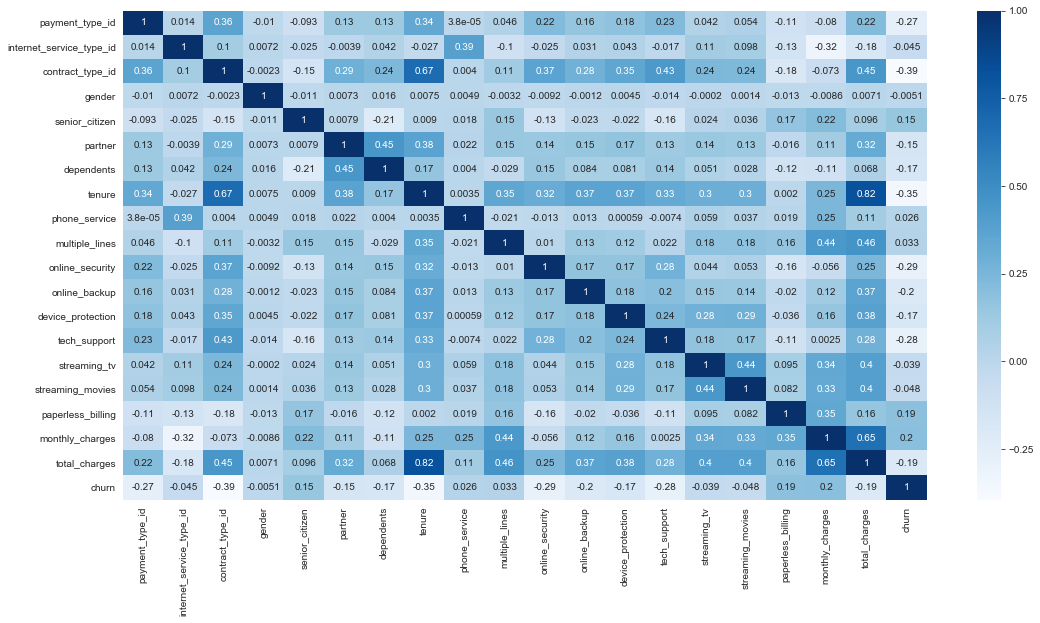

In [17]:
# Plot a heat map of the correlation between variables
plt.figure(figsize=(18,9))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

- Takeaway: There are way too many variables here. We should try to combine similar variables to create new features. Combine partner & dependents, online security & online backup, streaming tv & streaming movies

Question 1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))

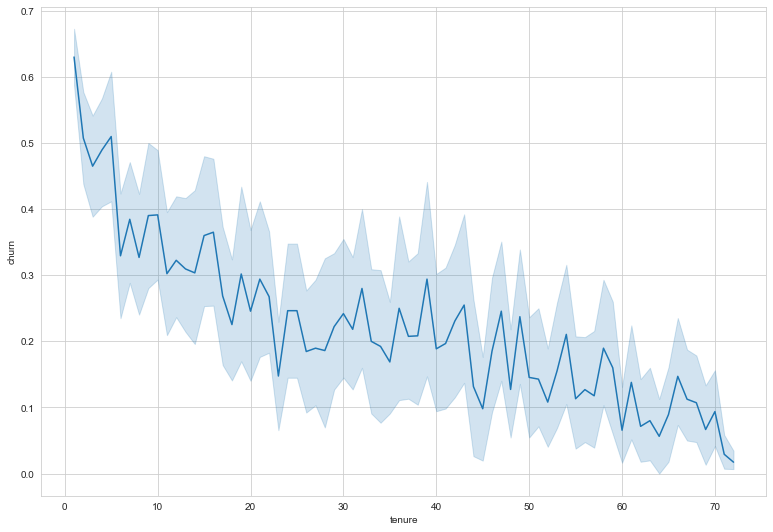

In [18]:
churn_tenure_line = train[['tenure', 'churn']]
plt.figure(figsize=(13,9))
au = sns.lineplot(x=churn_tenure_line.tenure, y= churn_tenure_line.churn)

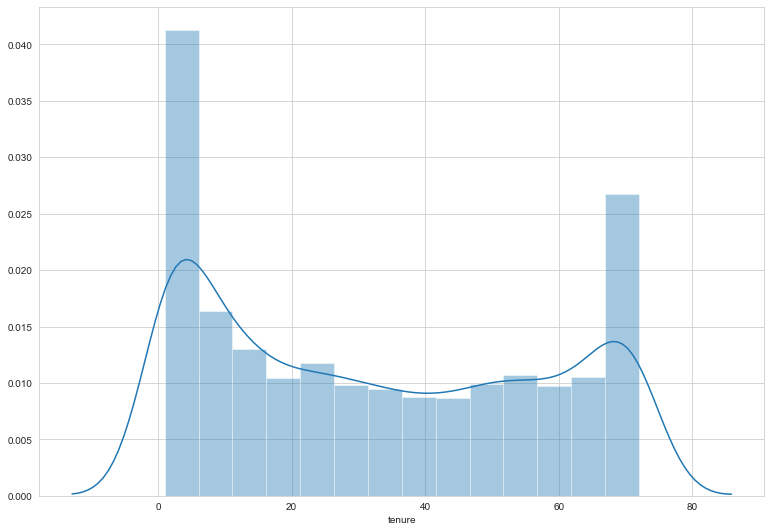

In [19]:
churn_tenure_dist = train[['tenure', 'churn']]
plt.figure(figsize=(13,9))
x = churn_tenure_dist.tenure
ax = sns.distplot(x)

Question 2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

Text(0, 0.5, 'Churn Rate')

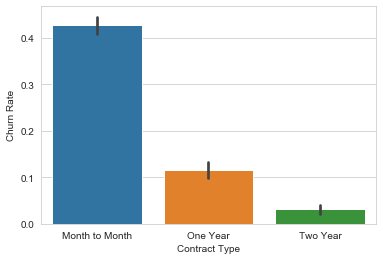

In [20]:
# Evaluate churn rate and internet service type
ax = sns.barplot(x=train.contract_type_id, y=train.churn)
ax.set_xticklabels(["Month to Month","One Year","Two Year"])
ax.set_xlabel("Contract Type")
ax.set_ylabel("Churn Rate")

- Takeaway: Customers with month to month contracts are more likely to churn than customers with yearly contracts. Contract type effects churn.

Text(0, 0.5, 'Churn Rate')

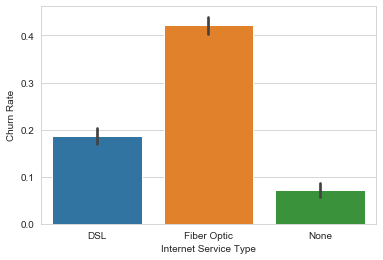

In [21]:
# Evaluate churn rate and internet service type
ax = sns.barplot(x=train.internet_service_type_id, y=train.churn)
ax.set_xticklabels(["DSL","Fiber Optic","None"])
ax.set_xlabel("Internet Service Type")
ax.set_ylabel("Churn Rate")

- Takeaway: Customers with Fiber Optic service have the highest churn rates. Internet service type effects churn.

Text(0, 0.5, 'Churn Rate')

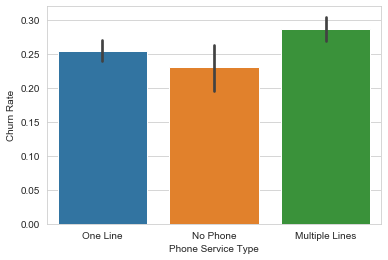

In [22]:
# Evaluate churn rate and phone service type
ax = sns.barplot(x=train.multiple_lines, y=train.churn)
ax.set_xticklabels(["One Line","No Phone","Multiple Lines"])
ax.set_xlabel("Phone Service Type")
ax.set_ylabel("Churn Rate")

- Takeaway: Churn rates are very similar across phone service. Phone service does not appear to effect churn rates.

Text(0, 0.5, 'Churn Rate')

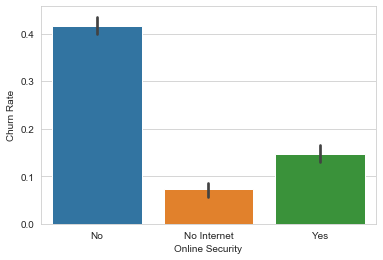

In [23]:
# Evaluate churn rate and online security
ax = sns.barplot(x=train.online_security, y=train.churn)
ax.set_xticklabels(["No","No Internet","Yes"])
ax.set_xlabel("Online Security")
ax.set_ylabel("Churn Rate")

Text(0, 0.5, 'Churn Rate')

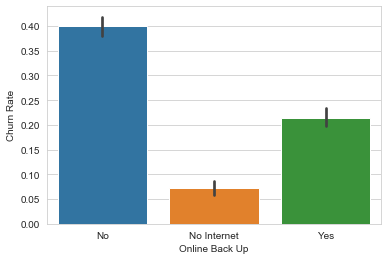

In [24]:
# Evaluate churn rate and online back up
ax = sns.barplot(x=train.online_backup, y=train.churn)
ax.set_xticklabels(["No","No Internet","Yes"])
ax.set_xlabel("Online Back Up")
ax.set_ylabel("Churn Rate")

- Takeaway: Customers who do not have online security or online back up have higher churn rates than those who do. These variables may effect churn. Their correlations are so similar that it would be best to only use one of the two for feature engineering.

Text(0, 0.5, 'Churn Rate')

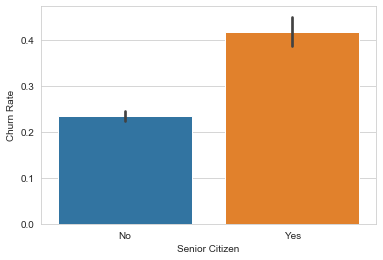

In [25]:
# Evaluate churn rate and senior citizen status
ax = sns.barplot(x=train.senior_citizen, y=train.churn)
ax.set_xticklabels(["No","Yes"])
ax.set_xlabel("Senior Citizen")
ax.set_ylabel("Churn Rate")

- Takeaway: Senior citizens have a higher churn rate than non senior citizen. This appears to be affecting churn.

Text(0, 0.5, 'Churn Rate')

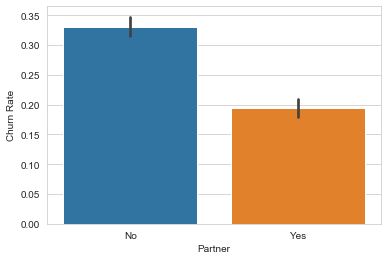

In [26]:
# Evaluate churn rate and partner status
ax = sns.barplot(x=train.partner, y=train.churn)
ax.set_xticklabels(["No","Yes"])
ax.set_xlabel("Partner")
ax.set_ylabel("Churn Rate")

- Takeaway: Single customers have a higher churn rate than those with parnters. This appears to be affecting churn.

Text(0, 0.5, 'Churn Rate')

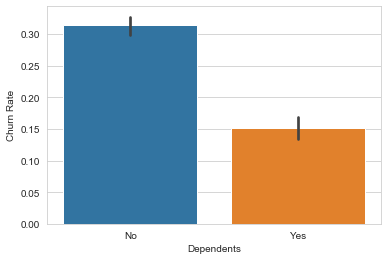

In [27]:
# Evaluate churn rate and dependents status
ax = sns.barplot(x=train.dependents, y=train.churn)
ax.set_xticklabels(["No","Yes"])
ax.set_xlabel("Dependents")
ax.set_ylabel("Churn Rate")

- Takeaway: Customers without dependents have a higher churn rate than those with dependents. This appears to be affecting churn.

Question 3: Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

Text(0, 0.5, 'Monthly Charges')

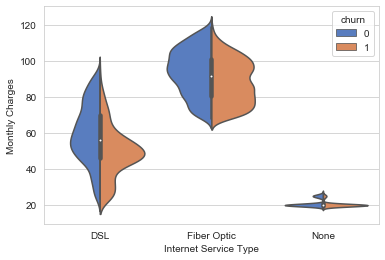

In [28]:
ax = sns.violinplot(x="internet_service_type_id", y="monthly_charges", hue="churn", data=train, palette="muted", split = True)
ax.set_xticklabels(["DSL","Fiber Optic","None"])
ax.set_xlabel("Internet Service Type")
ax.set_ylabel("Monthly Charges")

- Takeaway: There does not appear to be a price point for internet service that significanly influences churn.

Text(0, 0.5, 'Monthly Charges')

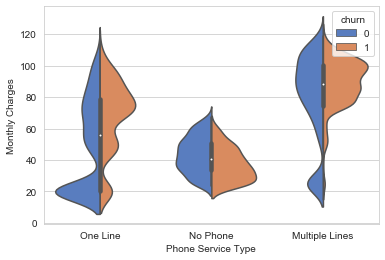

In [29]:
ax = sns.violinplot(x="multiple_lines", y="monthly_charges", hue="churn", data=train, palette="muted", split = True)
ax.set_xticklabels(["One Line","No Phone","Multiple Lines"])
ax.set_xlabel("Phone Service Type")
ax.set_ylabel("Monthly Charges")

- Takeaway: There does not appear to be a price point for phone service that significantly influences churnj.

Question 4: If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [30]:
train.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
5472,4,2,3,0,0,1,0,72,1,2,2,0,2,2,2,2,1,110.15,7881.20,0
5425,3,2,3,1,1,1,0,71,1,2,2,2,2,2,2,2,1,115.05,8016.60,0
3563,1,2,1,0,1,0,0,2,1,0,0,0,0,0,0,0,1,69.60,131.65,1
2096,2,1,3,0,0,0,0,47,1,0,0,0,2,2,2,2,0,74.45,3510.30,0
7008,2,3,3,0,0,1,1,56,1,2,1,1,1,1,1,1,1,24.45,1385.85,0


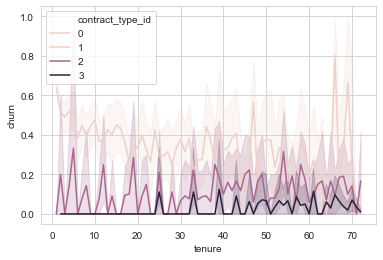

In [31]:
sns.lineplot(x="tenure", y="churn", hue="contract_type_id", data=train)

- Takeaway: Month to month customers still have higher churn rates than annual contract customers after 12 months of tenure.

Question 5: Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

Need more time to explore

Question 6: How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

Need more time to explore

Question 7: How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

Need more time to explore

Question 8: Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

This question has been answerd through visualizations above.

Question 9: What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation.

This question has been answered through takeaway summary points above.

Question 10: Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.

Contract type, tenure, and internet services seem to have the most important effects on churn. Gender was irrelevant while senior citizen status may or may not effect churn. Online security services correlate with churn rates, but this may just confirm the correlation of internet service with churn because those with internet service also have at least some form of security service.

## Feautre Engineering

In this section I will continue to explore the variables. I will drop insinificant variables to reduce the total number of variables. I will also scale variables based on their magnitude compared to other variables. After I have finished manipulating the variables, I will use them to experiment with different models and test for accuracy. 

In [32]:
# Preview current variables
X_train.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges
5472,4,2,3,0,0,1,0,72,1,2,2,0,2,2,2,2,1,110.15,7881.20
5425,3,2,3,1,1,1,0,71,1,2,2,2,2,2,2,2,1,115.05,8016.60
3563,1,2,1,0,1,0,0,2,1,0,0,0,0,0,0,0,1,69.60,131.65
2096,2,1,3,0,0,0,0,47,1,0,0,0,2,2,2,2,0,74.45,3510.30
7008,2,3,3,0,0,1,1,56,1,2,1,1,1,1,1,1,1,24.45,1385.85


In [33]:
# Drop customer_id becuase it is a string that won't play well with models.
X_train = X_train.drop(columns=(['multiple_lines', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']))

In [34]:
# Preview new X_train variables
X_train.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'online_security', 'paperless_billing',
       'monthly_charges', 'total_charges'],
      dtype='object')

In [35]:
# Do the same for test data to use later for testing.
X_test = X_test.drop(columns=(['multiple_lines', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']))

# Modeling

### Logistic Regression Model

In [36]:
# Create
logit=LogisticRegression(random_state =123)
# Fit
logit.fit(X_train,y_train)
# Predict
y_pred = logit.predict(X_train)
print('Accuracy of Logistic regression on training set: {:.2f}'.format(logit.score(X_train,y_train)))

Accuracy of Logistic regression on training set: 0.80


In [37]:
# Evaluate
# Confusion Matrix
cml = confusion_matrix(y_train,y_pred)
# Classification Report
crl=(classification_report(y_train,y_pred, output_dict=False))
print("Classification Report: \n\n",crl)

Classification Report: 

               precision    recall  f1-score   support

           0       0.84      0.90      0.87      4133
           1       0.65      0.53      0.58      1492

    accuracy                           0.80      5625
   macro avg       0.75      0.71      0.73      5625
weighted avg       0.79      0.80      0.79      5625



### Decision Tree Model

In [38]:
# Create
baseline_2 = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=123)
# Fit
baseline_2.fit(X_train, y_train)
# Predict
y_pred = baseline_2.predict(X_train)
# Evaluate accuracy (Checks number of correct predictions over the number of total instances that have been evaluated.)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(baseline_2.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.82


In [39]:
# Evaluate
# Confusion Matrix
cmdt = confusion_matrix(y_train,y_pred)
# Classification Report
crdt=(classification_report(y_train,y_pred, output_dict=False))
print("Classification Report: \n\n",crdt)

Classification Report: 

               precision    recall  f1-score   support

           0       0.86      0.90      0.88      4133
           1       0.69      0.59      0.63      1492

    accuracy                           0.82      5625
   macro avg       0.77      0.75      0.76      5625
weighted avg       0.81      0.82      0.82      5625



### K Nearest Neighbor Model

In [40]:
# Create
knn=KNeighborsClassifier(n_neighbors=10,weights='uniform')
# Fit
knn.fit(X_train,y_train)
# Predict
y_pred_knn=knn.predict(X_train)
# Score
print('Accuracy of k nearest neighbor on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of k nearest neighbor on training set: 0.81


In [41]:
# Evaluate
# Confusion Matrix
cmknn = confusion_matrix(y_train,y_pred_knn)
# Classification Report
crknn=(classification_report(y_train,y_pred_knn, output_dict=False))
print("Classification Report: \n\n",crknn)

Classification Report: 

               precision    recall  f1-score   support

           0       0.82      0.95      0.88      4133
           1       0.75      0.43      0.55      1492

    accuracy                           0.81      5625
   macro avg       0.79      0.69      0.71      5625
weighted avg       0.80      0.81      0.79      5625



### Random Forest Model

In [42]:
X_train.columns

Index(['payment_type_id', 'internet_service_type_id', 'contract_type_id',
       'gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'online_security', 'paperless_billing',
       'monthly_charges', 'total_charges'],
      dtype='object')

In [43]:
# Create
rf = RandomForestClassifier(min_samples_leaf=5, max_depth=10, random_state=123)
# Fit
rf.fit(X_train, y_train)
#Predict
y_pred_rf = rf.predict(X_train)

In [44]:
# Evaluate
# Score
print('Accuracy of Random Forest Classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))
# Confusion Matrix
cmrf = confusion_matrix(y_train,y_pred_rf)
# Classification Report
crrf=(classification_report(y_train,y_pred_rf, output_dict=False))
print("Classification Report: \n\n",crrf)

Accuracy of Random Forest Classifier on training set: 0.84
Classification Report: 

               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4133
           1       0.75      0.61      0.67      1492

    accuracy                           0.84      5625
   macro avg       0.81      0.77      0.78      5625
weighted avg       0.84      0.84      0.84      5625



### Takeaway: Random Forest is the most accurate algorithm. More importantly, it has the highest recall value for churn customers. This is important because false negatives are important to us. A false negative predicts a customer will not churn when they actually do. These errors are harmful top our business. One the other hand, false positives are when we predict a customer will churn but they actually don't. These errors are less harmful to us because we retain the customers' business. There is a much smaller price to pay for being wrong here.

## Testing our MVP Model:

In [45]:
y_pred_rf_test = rf.predict(X_test)

In [46]:
# Check probabilities for each prediction
y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_proba_rf

array([[0.99866667, 0.00133333],
       [0.49244643, 0.50755357],
       [0.96966874, 0.03033126],
       ...,
       [0.50527359, 0.49472641],
       [0.85188543, 0.14811457],
       [0.72864589, 0.27135411]])

In [47]:
# Evaluate
# Score
print('Accuracy of Random Forest Classifier on testing set: {:.2f}'
     .format(rf.score(X_test, y_test)))
# Confusion Matrix
cmrf_test = confusion_matrix(y_test,y_pred_rf_test)
# Classification Report
crrf_test=(classification_report(y_test,y_pred_rf_test, output_dict=False))
print("Classification Report: \n\n",crrf_test)

Accuracy of Random Forest Classifier on testing set: 0.80
Classification Report: 

               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1030
           1       0.65      0.52      0.58       377

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [66]:
print(cmrf_test)

[[924 106]
 [182 195]]


In [48]:
# Take a look at the stats.
FP = cmrf.sum(axis=0) - np.diag(cmrf)  
FN = cmrf.sum(axis=1) - np.diag(cmrf)
TP = np.diag(cmrf)
TN = cmrf.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

f1_score=(TPR+PPV)/2

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print("Accuracy: ", ACC)
print("True Positive Rate: ", TPR)
print("False Positive Rate: ", FPR)
print("True Negative Rate: ", TNR)
print("False Negative Rate: ", FNR)
print('Precision: ', PPV)
print("Recall: ", TPR)
print("F1-Score: ", f1_score)

Accuracy:  [0.84248889 0.84248889]
True Positive Rate:  [0.92571982 0.61193029]
False Positive Rate:  [0.38806971 0.07428018]
True Negative Rate:  [0.61193029 0.92571982]
False Negative Rate:  [0.07428018 0.38806971]
Precision:  [0.86855846 0.74836066]
Recall:  [0.92571982 0.61193029]
F1-Score:  [0.89713914 0.68014548]


In [49]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.80


# Creating a CSV file

In [50]:
# Get the customer_id and churn columns from data. Now we only need to add our probability predictions for each customer before exporting to csv. 
data = acquire.get_telco_data()
csv = data[['customer_id','churn']]
csv.head()

,customer_id,churn
0,0003-MKNFE,No
1,0013-MHZWF,No
2,0015-UOCOJ,No
3,0023-HGHWL,Yes
4,0032-PGELS,Yes


In [51]:
# Prep data
csv_data = acquire.prep_telco_data(data)

In [52]:
# Separate into X and y
X = csv_data.drop(columns=["churn"])
y = pd.DataFrame([csv_data.churn])
y = y.transpose()

In [53]:
# Drop customer_id becuase it is a string that won't play well with models. Drop gender becuase it has no significance.
X = X.drop(columns=(['multiple_lines', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']))
X.shape

(7032, 13)

In [54]:
y.shape

(7032, 1)

In [55]:
X_train.shape

(5625, 13)

In [56]:
y_train.shape

(5625, 1)

In [57]:
# Create
rf = RandomForestClassifier(min_samples_leaf=5, max_depth=10, random_state=123)
# Fit
rf.fit(X_train, y_train)
#Predict
y_pred_csv = rf.predict(X)
y_pred_csv_proba = rf.predict_proba(X)

In [58]:
y_pred_csv[:5]

array([0, 0, 0, 1, 0])

In [59]:
y_pred_csv_proba[:5]

array([[0.79724017, 0.20275983],
       [0.66573375, 0.33426625],
       [0.71924285, 0.28075715],
       [0.18555239, 0.81444761],
       [0.66405095, 0.33594905]])

In [60]:
# Evaluate
# Accuracy Score
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X, y)))
# Confusion Matrix
cmrf = confusion_matrix(y,y_pred_csv)
# Classification Report
crrf=(classification_report(y,y_pred_csv, output_dict=False))
print("Classification Report: \n\n",crrf)

Accuracy of random forest classifier on training set: 0.83
Classification Report: 

               precision    recall  f1-score   support

           0       0.86      0.92      0.89      5163
           1       0.73      0.59      0.65      1869

    accuracy                           0.83      7032
   macro avg       0.80      0.76      0.77      7032
weighted avg       0.83      0.83      0.83      7032



In [61]:
# New dataframe that contains the probabilites and predictions 
y_predictions = pd.DataFrame({'Probability': y_pred_csv_proba[:,1], 'Predictions': y_pred_csv})

In [62]:
y_predictions.head()

,Probability,Predictions
0,0.202760,0
1,0.334266,0
2,0.280757,0
3,0.814448,1
4,0.335949,0


In [63]:
# Create the index to be the "customer_id"
y_predictions = y_predictions.set_index(csv.customer_id)

In [64]:
y_predictions.head()

,Probability,Predictions
customer_id,,
0003-MKNFE,0.202760,0
0013-MHZWF,0.334266,0
0015-UOCOJ,0.280757,0
0023-HGHWL,0.814448,1
0032-PGELS,0.335949,0


In [65]:
# Create csv file
y_predictions.to_csv(r'probability_and_predictions.csv')